## Computer Vision Base Trainer

The basic steps we'll take are:

1. Importing our collected, organized, and cleaned images
1. Fine-tune a pretrained neural network model to take images as inputs and output category labels
1. Try running this model on a picture from our test dataset and see if it works.

## STOP HERE, THIS IS THE BASE TRAINER, MAKE A COPY AND DO YOUR WORK THERE

Describe what you want to do for this training here:

Item Transforms:

Batch Transforms:

Pre-Trained Model: 

Batch Size:  

Validation Size: 

Epochs: 


## STEP 0: Ensure you are running this notebook within a Docker Container

View the README.md file for instructions on building and running a container.

## STEP 1: Import the image data to the workspace so we can use them to train a model

The Docker container will create a nice `workspace` for us that we can recreate if we ever need to start over from scratch. This can allow us to try many different things from the same starting point if we want.

The folder structure for this workspace is
 - data (our collected data will be placed here)
 - images (other images we may need that is not the data)
 - models (models we choose to save will be stored here)
 - notebooks (the notebooks we run can be found in this directory)

**We want to store all of our data in the `/workspace/data` folder**

Keeping all of the data in one place helps us to stay organized, we will always know where to look for the data. 

This repository is also setup so that the data folder is never included in the repository files. So if you are working with a large amount of data, or even sensitive data, that data will not be uploaded to GitHub.

### How do we access the `/workspace/data` folder using code?

Within our code, we can use both **absolute** and **relative** paths. 

For example, this notebook is located in the `4 - Day Four` folder inside `notebooks` and has an absolute path of  
`workspace/notebooks/4 - Day Four - Training A Model With Collected Data`  

To reference a file in the data folder from this notebook we can use the following options below:
 - absolute path: `/workspace/data/FILENAME.zip`
 - relative path: `../../data/filename.zip` (the `..` in this case means from where this file is, go up one folder)

### How do we upload our data into the workspace?

The jupyter notebook environment we are working in has a quick way for us to upload files into the data folder for us to work with. The zip file we will be working with for this lesson is already included as part of the repository, so you don't need to upload any files at this time, but make a note that these instructions will help you pull in your own data in the future.

1. Go to the `Home` tab in the browser that should still be open, this is the page where you opened this notebook from.  
    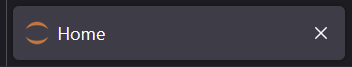

   
1. Click on the root folder icon (if you hover over it, it might say "Jupyter Server Root").  
    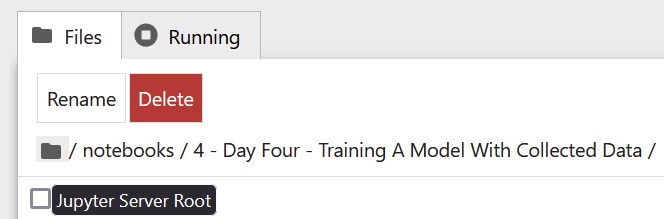


1. Now that you are in the root folder, or `/workspace/`, double click on the `data` folder to open it. You may see some files in there from earlier lessons.  
    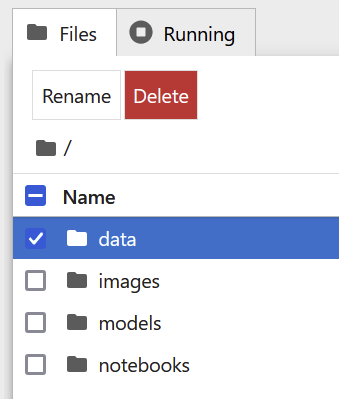


1. In the `/workspace/data` folder, click on the `Upload` button in the top right, find the zip file you want to use on your computer, and click the `Open` button.  
    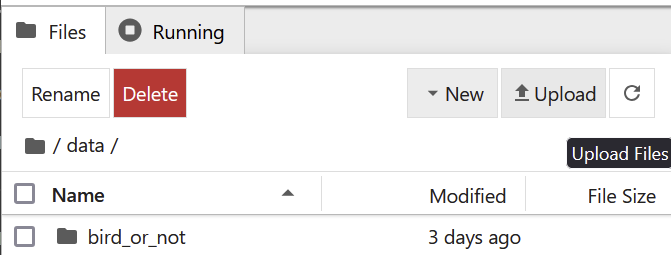


1. You should now see the zip file in that folder within the jupyter notebook environment. In the example below, I imported a zip file called `pets.zip`.  
    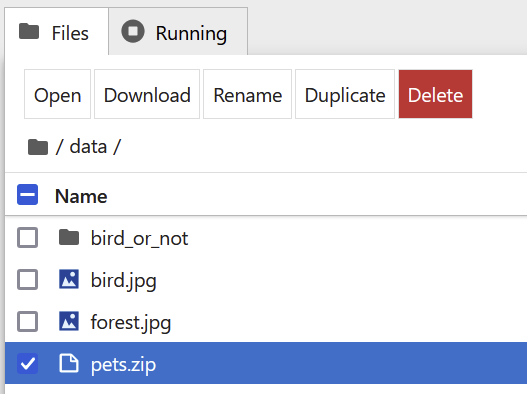

### How do we unzip the file with the data so that it can be used for training?

The code below imports libraries `zipfile` and `os` so that we can work with the filesystem. Take a close look at the comments for each line as explanations for what will happen when we run the code in that cell.

The variable you would need to modify to unzip the `pets.zip` file is `zip_file_name`. This variable should not remain as `TRAINING_DATA` unless that is the name of your zip file.

**You need to change the `zip_file_name` value to the filename of *your* data**  
If your data is in a zip file called `plant_data.zip` you need to set the `zip_file_name` variable to `'plant_data'`.

`zip_file_name = 'plant_data'`

In [1]:
import zipfile
import os

# Define the path to the zip file and the extraction directory
zip_file_name = 'TrainingData' # You will want to change this filename to the filename of your data

zip_file_path = f"/workspace/data/{zip_file_name}.zip" # You should not need to edit anything here because the zip_file_path references the variable containing the filename above, this code assumes it will be a zip file
extract_to_dir = '/workspace/data/' # This is where the extracted zip file will go, turning that one zip file into the directories and images files that we will need to work with for training

# Check if the TRAINING_DATA directory already exists
if not os.path.exists(extract_to_dir+zip_file_name): # If the directory with the real data doesn't exist, run the code inside this if statement. 
    # Create the extraction directory if it doesn't exist
    os.makedirs(extract_to_dir, exist_ok=True) # Since the directory does not exist, it needs to be created

    # Open the zip file and extract its contents
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref: # These two lines extract the data from the zip file, and place them in the defined path for the extract_to_dir variable
        zip_ref.extractall(extract_to_dir)

    print(f"Extracted all files to {extract_to_dir}") # Recall that print statments can be very useful, this print statement let's you know that the extraction process has completed
else: # This else block will only run if the directory with the real data already exists. If you need to unzip the data again, you will have to remove this directory inside the /workspace/data/ directory
    print(f"Directory {extract_to_dir}{zip_file_name} already exists. Skipping extraction.") # Since this block only runs if the directory already exists, it's helpful to get a message that it's already there


Directory /workspace/data/TrainingData already exists. Skipping extraction.


Depending on the size of your zip file, and the amount of data you are importing, this may take a while. But once you have extracted the data, the Docker container is setup so that it will persist (stay around) when you come back to this notebook again.

*NOTE: You do not want to run this cell until the zip file has been fully uploaded to the `/workspace/data/` directory. If you see an error that the zip file is not a zip file, but you know that it is, it has not finished uploading yet.*

## Step 2: Train an initial model so that we clean our data

The goal of step 2 is to do a light run of the training in order to clean up our data. While it may seem to make the most sense to clean the data by looking at every picture before we even attempt to train (and you should definitely give your data a look through), cleaning after running a few epochs of fine tuning can be very helpful.

We will be using the FastAPI library from Fast.AI to train our models. Documentation for this library can be found at [https://docs.fast.ai/](https://docs.fast.ai/).

For our purposes, we will be working within the subset of the API for **Computer Vision**.
 - This means we do not need to import all of fast ai (`import fastai`).
 - Instead, we will just need to import the subset of the api for `vision` (`from fastai.vision.all import *`)
   - note that the `*` here means everything within `fastai.vision.all`
 - We also need to import the Pytorch Image Models library so that we can use more than the Resnet models if we choose.
   - `import timm`
   - Documentation can be found at [https://timm.fast.ai/](https://timm.fast.ai/).

In [2]:
from fastai.vision.all import *
import timm

Now that we have access to the tools we will need for training, it can be helpful to set a variable for the `path` to where the data is stored. I often put mine in a directory called *TRAINING_DATA*, but yours should be the same as the name extracted from the zip file you unpacked above.

Continuing the example from above, if the data is in a folder called `plant_data` I would modify the assignment of `path` to be:  
`path = /workspace/data/plant_data`.

In [7]:
path = '/workspace/data/TrainingData'

Now that the location of the data is set in a variable, we *might* want to verify that all of our data is image data. If you have collected and organized all of the data, and are confident you don't have any random files in the directories, you may not need this. But, it can be helpful to run it once to ensure we won't have filetype issues going forward.

In [8]:
#HELPER
# only run this test if you've added new data to the training data
# it does NOT need to be run if you're confident that the image files are valid 
failed = verify_images(get_image_files(path)) # this looks at all of the files in our defined path and verifies that they are images, and failures will be placed in the failed variable
failed.map(Path.unlink) # if there are any failes that were not images, remove them from the data
len(failed) # show the number of failed files, ideally this will be 0, but even if it's more than 0 know that those files are now gone and we don't need to worry about them

0

To train a model, we'll need a `DataLoader`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of a model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it using the code below.

If you need a refresher, please visit the `01-datablocks-and-dataloaders` notebook.

In [9]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, 'squish'),#RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=aug_transforms()
).dataloaders(path, bs=256)

Here what each of the `DataBlock` parameters means:

    blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest"). Meaning we can send it a picture and it will give us some text.

    get_items=get_image_files, 

To find all the inputs to our model, run the `get_image_files` function (which returns a list of all image files in a path).

    splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

    get_y=parent_label,

The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be the names of each plant).

    item_tfms=RandomResizedCrop(224, min_scale=0.3)

Before training, resize each image to 224x224 pixels by randomly resizing and cropping each item. The `min_scale=0.3` parameter sets the amount of the image to select *at a minimum*.

    batch_tfms=[
        *aug_transforms(size=224, min_scale=0.75, p_lighting=0.8, do_flip=true),
        Normalize.from_stats(*imagenet_stats)
    ]

For each batch, which is 256 at a time for this code, set the minimum amount of scaling to 75%, the probability of changing the lighting (p_lighting) of the image to 80%, and use random flipping (do_flip=true) for each batch of the data.

Read more about data augmentations, whether at the item level, or batch level, at [https://docs.fast.ai/vision.augment.html](https://docs.fast.ai/vision.augment.html) (you will want to scroll to the bottom to see a list of these parameters)

The code above let's us take a look at how a batch (256 in the code above, `bs=256`) of the data is augmented based on the parameters of the `DataBlock`. 
You should see images that have been:
 - squished into 224 x 224 pixel sized squares (`size=224`)
 - some random cropping that always keeps at least 30% of the image (`RandomResizedCrop(224, min_scale=0.3)`)
 - a change in the brightness or contrast (`p_lighting=0.8`)
 - some random flipping (`do_flip=true`)

These augmentations allow our data to become more than just what the image originally was. Our model doesn't need to require that the original image was taken upside-down sometimes, but can account for that possibility through the data augmentation.

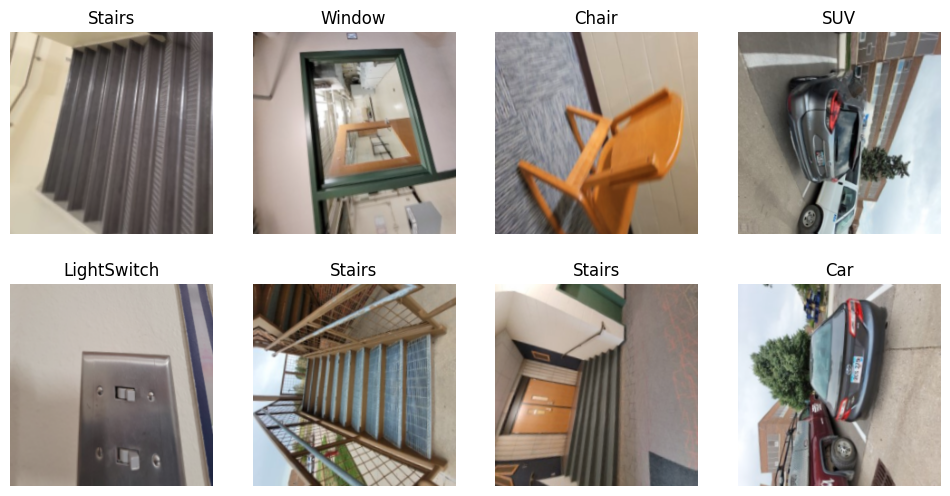

In [10]:
dls.show_batch(max_n=8, nrows=2, ncols=4)

We will use a learner to train a model on a pre-trained model, meaning a model that is already effective for taking images as inputs, and providing categories/labels/names as outputs. 

You can think of a learner as a toddler that is learning what things are in the world. It is going to use the `DataLoader` from above, which can be thought of the as the environment that the toddler is in, such as things it can see (images) and words that it knows (categories). This toddler/learner is then going to use a method from the pre-trained model to go about learning what categories match to which images. That analogy is not entirely correct, but it should provide some idea of how we're putting all this together.

There are many models out there, and a fast, and widely used computer vision model is `resnet18`, which is a pre-trained model that already works for other images. The `resnet18` model was trained on the ImageNet dataset, which is comprised of significantly more images and categories than we are likely to use in this trainer notebook. It is a *pre-trained* model that we can build upon, instead of needing to develop a model from scratch. The `18` referes to the number of layers in the model. Other options are `resnet34`, `resnet50`, `resnet101`, and `resnet152`. To use any of these other pre-trained models, you simply replace `resnet18` with the one you prefer below in the `vision_learner()` parameters. 
Example: `learn = vision_learner(dls, resnet101, metrics=error_rate)`

More information about pretrained models, and others that you may want to use instead of `resnet18` can be found at [https://www.kaggle.com/code/jhoward/which-image-models-are-best](https://www.kaggle.com/code/jhoward/which-image-models-are-best).

**The code below creates a learner, and in this case a vision_learner since we are working within *computer vision.***

More information about learners in can be found at [https://docs.fast.ai/learner.html](https://docs.fast.ai/learner.html).

### How can I pick a model?

There are lots of models available through the Pytorch Image Models library. Since we've already installed and imported that library, let's take a look at what is available.

We're interested in using a pre-trained model, so we need to include that as a parameter when we create a `vision_learner`.

The code below lists all pretrained models available to us from the `timm` library.  
`timm.list_models(pretrained=True)`

In [11]:
timm.list_models(pretrained=True)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

For example, if we want to use a `levit` model, let's see what is available in the `timm` library by passing a string into the `timm.list_models()` function.

Note that the star (`*`) at the end of the string will return anything that starts with 'levit'.

In [12]:
timm.list_models('levit*', pretrained=True)

['levit_128.fb_dist_in1k',
 'levit_128s.fb_dist_in1k',
 'levit_192.fb_dist_in1k',
 'levit_256.fb_dist_in1k',
 'levit_384.fb_dist_in1k',
 'levit_conv_128.fb_dist_in1k',
 'levit_conv_128s.fb_dist_in1k',
 'levit_conv_192.fb_dist_in1k',
 'levit_conv_256.fb_dist_in1k',
 'levit_conv_384.fb_dist_in1k']

As you can see, there are many to choose from.

Let's try to use something other than a Resnet model. Notice that we will need to provide a string to the `vision_learner` function that is the name of the pre-trained model we want to use.

If I were to choose the `'levit_384.fb_dist_in1k'` model, I need some extra information, such as the required size of the images.

In [13]:
# Model name
model_name = 'levit_384.fb_dist_in1k'

# Create the model instance
model = timm.create_model(model_name, pretrained=True)

# Retrieve the default configuration
default_cfg = model.default_cfg
print(default_cfg)

pytorch_model.bin:   0%|          | 0.00/157M [00:00<?, ?B/s]

{'url': '', 'hf_hub_id': 'timm/levit_384.fb_dist_in1k', 'architecture': 'levit_384', 'tag': 'fb_dist_in1k', 'custom_load': False, 'input_size': (3, 224, 224), 'fixed_input_size': True, 'interpolation': 'bicubic', 'crop_pct': 0.9, 'crop_mode': 'center', 'mean': (0.485, 0.456, 0.406), 'std': (0.229, 0.224, 0.225), 'num_classes': 1000, 'pool_size': None, 'first_conv': 'stem.conv1.linear', 'classifier': ('head.linear', 'head_dist.linear')}


Note that the `input_size` in the configuration is `(3, 224, 224)` *AND* it has a `fixed_input_size` of `True`, which means that we will need to ensure  that our images are resized to `224` in the `DataBlock` parameters. Modify that code above and rerun the cell if needed for a chosen pretrained model.

For example, if we wanted to use the model `'levit_384.fb_dist_in1k'` then we would run the code cell:  
`learn = vision_learner(dls, 'levit_384.fb_dist_in1k', metrics=error_rate)`

But, the Resnet models do seem to run fast and work well for a first experiment, so this default code uses `Resnet34`. Feel free to change the model if you choose.

In [14]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:04<00:00, 18.4MB/s]


Once we have a learner, we will want to find an optimal learning rate, which can be thought of as the step size to take during the learning (fine tuning). Too small of a learning rate, and it might take a long time to find the best model for our data. Too large of a learning rate and we might jump right over the best model for our data.

We will use the value that the code below (`learn.lr_find`) returns when we fine tune the model for our dataset.

More information about the learning rate can be found at [https://medium.com/@bijil.subhash/transfer-learning-how-to-pick-the-optimal-learning-rate-c8621b89c036](https://medium.com/@bijil.subhash/transfer-learning-how-to-pick-the-optimal-learning-rate-c8621b89c036).

*If you get an error that states `RuntimeError: CUDA error: out of memory`, reduce the batch size value `bs=` in the `dataloaders()` parameters above.*

SuggestedLRs(valley=0.0008317637839354575)

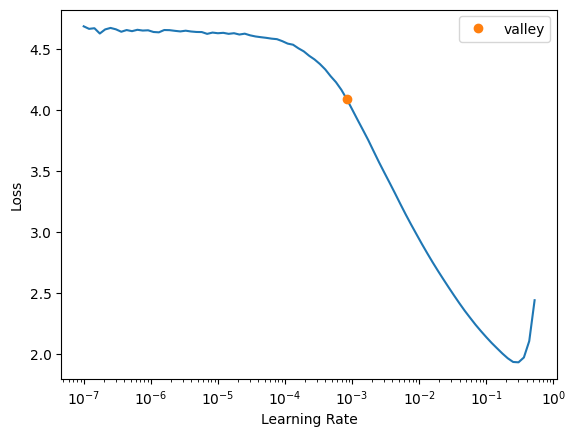

In [15]:
learn.lr_find() # find the learning rate

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the *pretrained model*), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in *imagenet*, and widely-used computer vision dataset with images covering 1000 categories) For details on fine-tuning and why it's important, check out the [free fast.ai course](https://course.fast.ai/).

**Recall that in this *step* we are training in order to clean the data. 3 epochs should be adequate for this, and it is suggested you don't try to train here as if this is the final step.**

*If you get an error that states `RuntimeError: CUDA error: out of memory`, reduce the batch size value `bs=` in the `dataloaders()` parameters above.*

In [16]:
learning_rate = 0.0020892962347716093 # use the value from the lr_find() method above

In [17]:
initial_training_epochs = 3
learn.fine_tune(initial_training_epochs, base_lr=learning_rate) 

epoch,train_loss,valid_loss,error_rate,time
0,1.510714,0.057359,0.018417,09:50


epoch,train_loss,valid_loss,error_rate,time
0,0.057058,0.001251,0.000392,14:11
1,0.021303,0.000211,0.000000,13:57
2,0.010233,0.000318,0.000000,21:22


### What are train_loss, valid_loss, and error_rate?

1. train_loss:
    - **Definition:** This is the loss calculated on the training dataset.
    - **Purpose:** It measures how well the model is performing on the training data. *A lower training loss generally indicates that the model is fitting the training data well.*
    - **Calculation:** During each epoch, the model makes predictions on the training data, and the difference between these predictions and the actual targets (ground truth) is computed using a loss function (e.g., cross-entropy loss for classification tasks). This difference is the training loss.

1. valid_loss:
    - **Definition:** This is the loss calculated on the validation dataset.
    - **Purpose:** It provides an estimate of how well the model is performing on unseen data. *A lower validation loss indicates better generalization to new data.*
    - **Calculation:** After each epoch, the model's performance is evaluated on the validation set, which is separate from the training set. The predictions on the validation data are compared to the actual targets to compute the validation loss using the same loss function as for training.

1. error_rate:
    - **Definition:** This is the proportion of incorrect predictions made by the model on the validation set.
    - **Purpose:** It is a common metric for classification tasks, indicating the accuracy of the model. *A lower error rate means higher accuracy.*
    - **Calculation:** It is computed as the number of incorrect predictions divided by the total number of predictions made on the validation set. If the model predicts the wrong class for a validation example, it counts as an error.

Now that our initial pass has completed, let's look at the results.

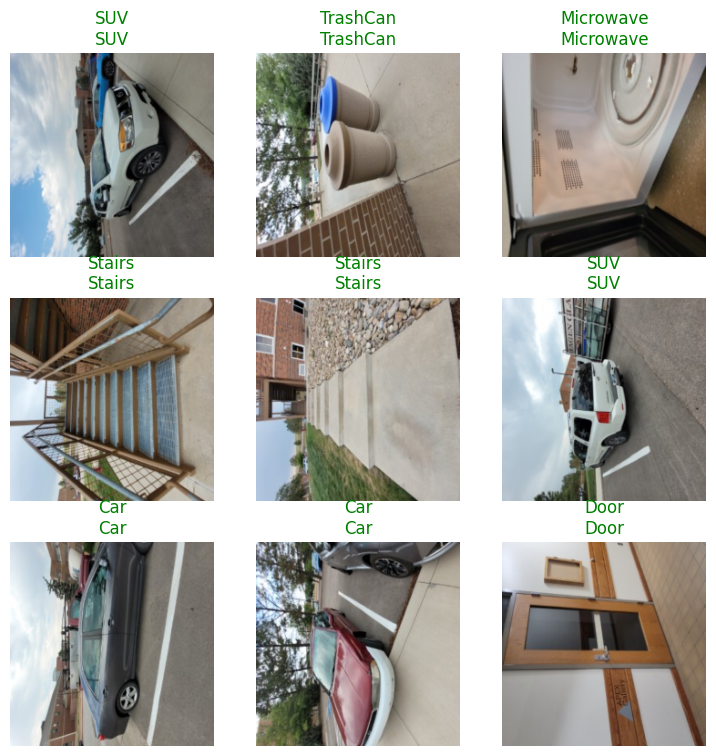

In [18]:
learn.show_results()

## Step 3: Let's see how our model did and what it had the most difficulty with

To interpret the predictions for our model we will use an interpretation function. Since we are specifically interested in classification for this model (giving it a piece of data and receiving a category label), we will use the `ClassificationInterpretation` class and tell it to interpret from the learner we've been using so far.

Documentation can be found at [https://docs.fast.ai/interpret.html](https://docs.fast.ai/interpret.html).

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

Now that we have our interpretation, let's examine a confusion matrix for the model. Running the cell below will show the percentage of categories that were either correctly, or incorrectly, identified. If you would prefer to see the raw numbers of elements, modify the `normalize` parameter to `False`.

You can read more about the what a confusion matrix shows at [https://www.geeksforgeeks.org/confusion-matrix-machine-learning/](https://www.geeksforgeeks.org/confusion-matrix-machine-learning/)

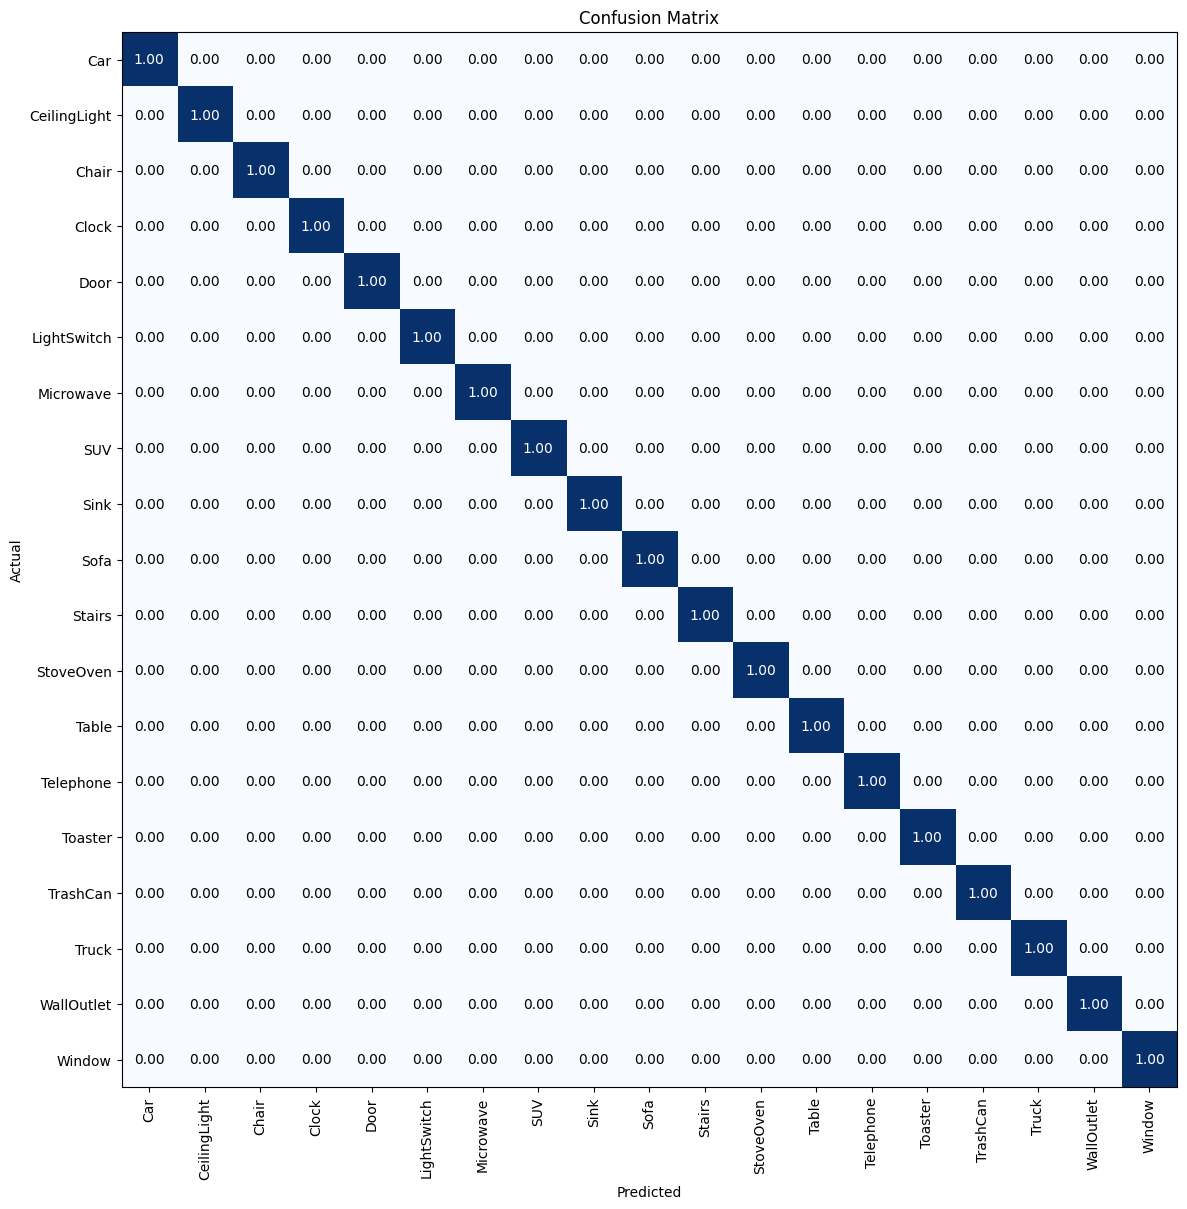

In [20]:
interp.plot_confusion_matrix(normalize=True, title='Confusion Matrix', figsize=(12, 12))

We can also use our interpretation to show items in our dataset that the model had the most trouble with. The `plot_top_losses` method below may show high confidence (probability) that an image is one category (prediction), but it was actually (actual) organized in the data as another. We will be able to clean up any mislabeled data in Step 5.

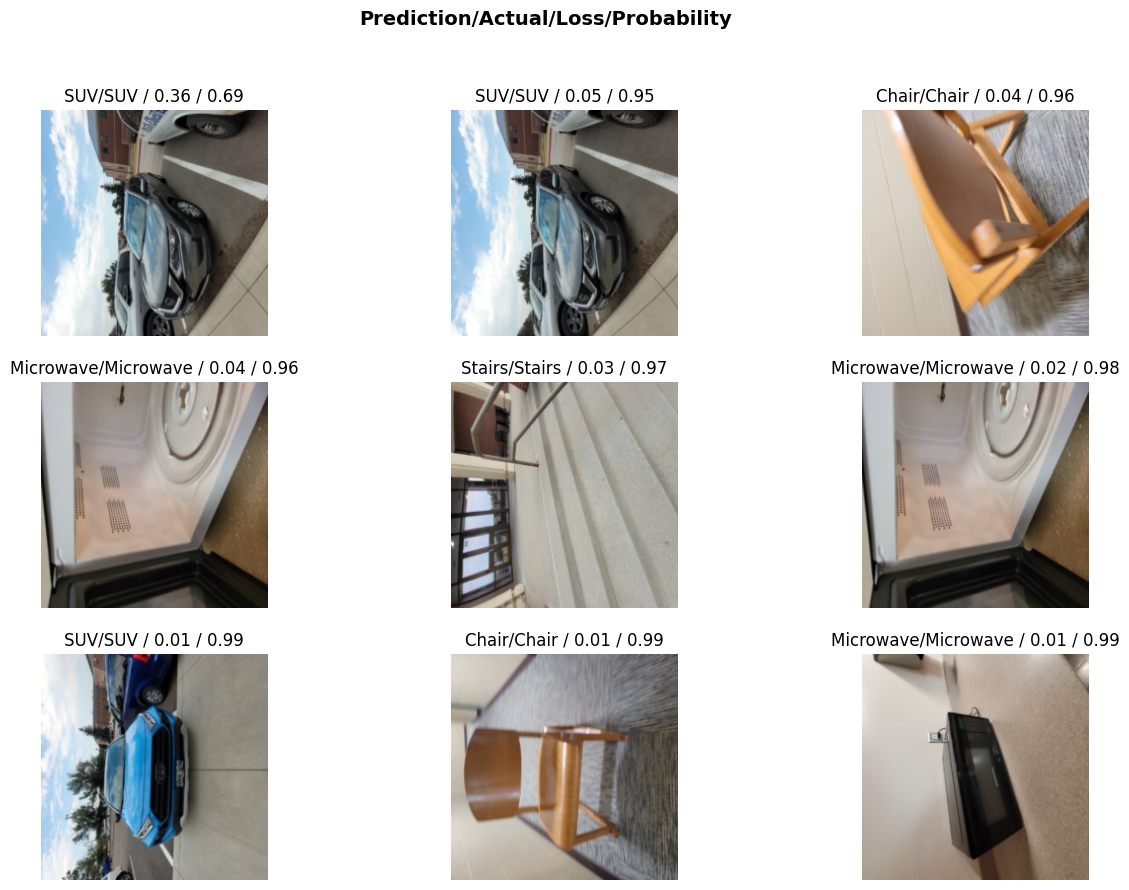

In [21]:
interp.plot_top_losses(9, figsize=(15,10))

And finally, if you want to test out individual files you can use the code below. I suggest creating a new folder called `TEST_IMAGES` in `/workspace/images/` and uploading some files to test there. This should result in an image with the filename `yarrow.jpg` having a full path of `/workspace/images/TEST_IMAGES/yarrow.jpg`.

The code below will use that path, show you a thumbnail of the image, and then use `learn.predict()` to return an identified category.

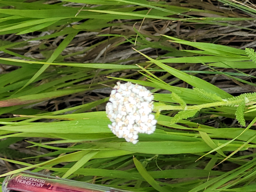

In [22]:
img_file = 'yarrow.jpg'
img_path = f"/workspace/images/TEST_IMAGES/{img_file}"
Image.open(img_path).to_thumb(256,256)

In [23]:
category,_,probs = learn.predict(PILImage.create(img_path))
print(f"This is a: {category}.")

This is a: CeilingLight.


## Step 4: Let's clean the data

At this stage, we may have identified some bad or mislabeled data. We will use the `ImageClassifierCleaner` function on our learner to let us modify any labels, or potentially remove data, directly from this notebook.

You may find that large collections of data may have been mislabeled, which may result in actually modifying the data found in `/workspace/data/`. You should feel free to do this, but you will likely want to run steps 2-3 again on this modified data. Situations like this can occur if multiple sets of data are being put into one large collection of data and end up in the wrong folder.

When using the cleaner below, you should know that what you see is organized in order of lowest probability to highest. So the first images are the most likely to be challenging for our model. Using the drop-down tool under each image, you can choose to **keep** that image with that category, **delete** it, or **move it to a new category**. You will want to examine every category, for both the training, and the validation, sets of data. 

A quick reminder that these were created using the `splitter` parameter in the `DataBlock` earlier. If you have left that code as is, this resulted in 20% of the data being used for the validation set, and 80% being used for training (`splitter=RandomSplitter(valid_pct=0.2, seed=42)`).

In [24]:
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

Once you have cleaned the data, the code below will use a `for` loop to enact any of the modifications you made on the data.

In [25]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

Finally, if you are satisfied with your trained `Learner`, then you can export the file that contains all the information needed to use the model elsewhere, whether that be in an application or for futue training.

**However, we just cleaned the data, maybe we don't want to save this model and start at the beginning with a cleaned up dataset.**

In [26]:
learn.export('/workspace/models/model.pkl')

## Step 5: Now We Train A Model Using What We've Learned

Here's what we have at this point:
 - A data learner that can run effectively using our chosen parameters
 - The batch size that let's us optimally utilize the resources on our computer
 - The learning rate that is effective for the data_learner and data
 - A cleaned up dataset to work with for training

We now know a lot about our data and model, likely enough to run a train for many epochs. Use the variables below to setup your script to:
 1. set how many epochs should be run in between saves
 1. provide the path to a previously saved model if you want to start from there

*Note 1: load_learner requires all your custom code be in the exact same place as when exporting your Learner (the main script, or the module you imported it from). So don't modify this script after you've exported the model.*

*Note 2: models may not be small, you will want to account for the amount of space you have on your computer and how many saves you may trigger while training. If your model is 50MB, and you will save 10 times, that turns into 500MB of models stored on your computer.*

*Note 3: Notice that the learning rate is not defined here. It has already been set earlier, and we do not need to recreate it.*

Here is an explanation about what is happening in the code below.

Custom Callback:
 - `SaveModelCallback` is a custom callback that saves the model every `self.every` epochs, appending the epoch number to the file name.

Jupyter Notebook:
 - Load the model and data loaders as before.
  - You will either continue running from a .pth file, or .pkl file. The default is from a .pkl file and is set using `recover_from_pth_file`
 - Instantiate the `SaveModelCallback` and pass it to `learn.fine_tune` using the `cbs` parameter.
 - Save the final model at the end.

**Good luck with your model training**

In [28]:
#first set how often the model should save a checkpoint file, these will be stored as .pth files, not .pkl
# not that .pth files will contain the model architecture, whereas .pkl files do not, which means .pth files are much larger in size
last_epoch_save = 0 # leave this value as zero if you are starting over from cleaned data
save_after_this_many_epochs = 5 # a .pth checkpoint file will be created every 5 epochs
model = resnet34
path = '/workspace/data/TrainingData' # ensure this points to your data
# Define the number of additional epochs you want to train for
additional_epochs = 20  # Set the total number of epochs to run in the cell below
learning_rate = 0.0020892962347716093 # use the value from the lr_find() method above
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224, 'squish'),#RandomResizedCrop(224, min_scale=0.3),
    batch_tfms=aug_transforms()
).dataloaders(path, bs=256)

In [ ]:
from fastai.callback.core import Callback
from fastai.learner import load_learner
from fastai.data.core import DataLoaders

# SaveModelCallback will be triggered on each epoch, The default is 10 epochs, but you can set the amount using the save_after_this_many_epochs variable
class SaveModelCallback(Callback):
    def __init__(self, every=10, path='model', last_epoch_save=0):
        self.every = every
        self.path = path
        self.last_epoch_save = last_epoch_save

    def after_epoch(self):
        "Save the model every `self.every` epochs"
        if (self.epoch + 1) % self.every == 0:
            self.learn.save(f'{self.path}_epoch{self.epoch + (1+self.last_epoch_save)}')

# Define your data recover function, this function will return .pkl model from one of your checkpoint save files in the .pth format
# path = the path to your data (e.g. /workspace/data/TRAINING_DATA), path_to_pth_model = the path to your last saved .pth file
def recover_dl_from_pth(path, path_to_pth_model):
    dls = ImageDataLoaders.from_folder(path)
    learn = cnn_learner(dls, model) # be sure to use the same pretrained model here that you did for previous training, the model variable set above
    learn.load(path_to_pth_model)  # Load the model from the .pth file into the learn variable
    return learn # return the learn variable

# Load the previously trained model
recover_from_pth_file = False

if(recover_from_pth_file):
    # The code below will create a learner recovered from a checkpoint save
    # You will want to make sure that the pretrained model in recover_dl_from_pth() the same as what was used for fine tuning earlier
    learn_long = recover_dl_from_pth(path, '/workspace/models/model_epochEPOCH_NUM_HERE_TO_GET_TO_CORRECT_FLE.pth')
else:
    # This code will start at 0 or recover from a .pkl file
    if(last_epoch_save > 0):
        previous_model_path = '/workspace/models/MODEL_FILENAME.pkl'  # replace with your actual model path
        learn_long = load_learner(previous_model_path) #note that this is creating a different learner than the one we used above
    else:
        learn_long = vision_learner(dls, model, metrics=error_rate) # create the learner
    # Ensure data loaders are set up
    learn_long.dls = dls # path is the path to our data, which was set earlier

# Instantiate the custom callback
# modify last_epoch_save to be the number of epochs the model was trained up to
save_model_callback = SaveModelCallback(every=save_after_this_many_epochs, path='/workspace/models/model', last_epoch_save = last_epoch_save)

# Continue training the model with the custom callback
learn_long.fine_tune(additional_epochs, base_lr=learning_rate, cbs=[save_model_callback])

# Save the updated model at the end
updated_model_path = f'/workspace/models/model_epoch{(last_epoch_save+additional_epochs)}.pkl'
learn_long.export(updated_model_path)

print("Training completed and model saved.")


epoch,train_loss,valid_loss,error_rate,time
0,1.482426,0.038990,0.009404,10:55


epoch,train_loss,valid_loss,error_rate,time
0,0.067834,0.003436,0.000392,14:21


After all of that training, you may want to take another look at the confusion matrix. How does it compare to your initial model?

In [ ]:
interp_long = ClassificationInterpretation.from_learner(learn_long)
interp_long.plot_confusion_matrix(normalize=True, title='Confusion Matrix', figsize=(12, 12))